# Draw an example river basin, country overlap diagram and calculate overlap fractions
## Warning: Version 0.0 (not tested. Remove this when done)

### note to novice programmers: The following is not examples of good practices in coding. Done in a hurry to get one-off things done. Do not learn style from these 
### 2024-OCT-14 Assela Pathirana

In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx



C:\Users\apa\AppData\Local\Temp\ipykernel_6104\668952440.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


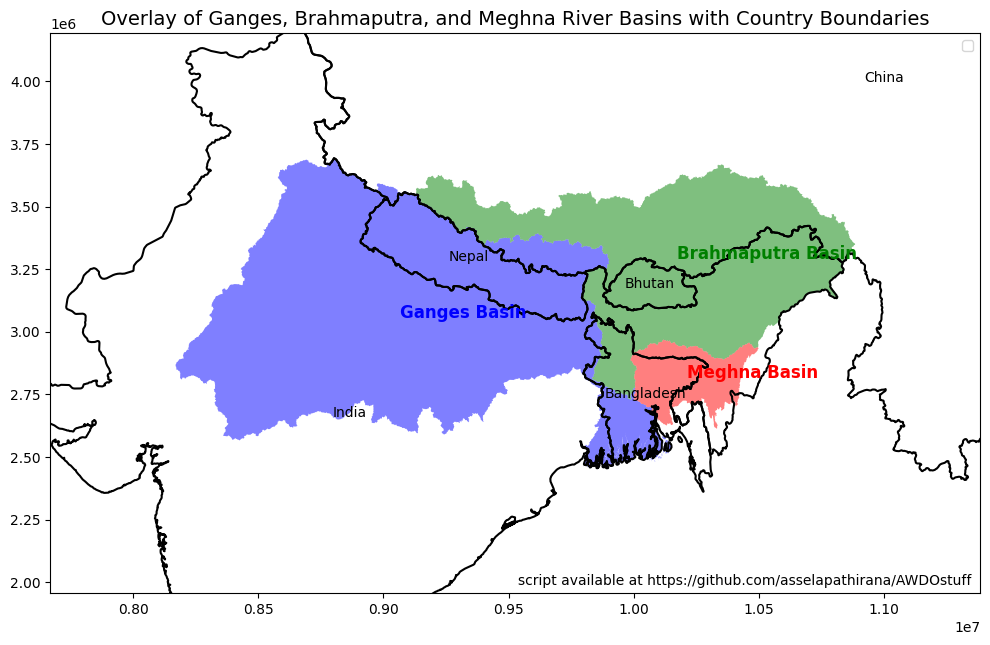

In [38]:


# Load the country boundaries shapefile from Natural Earth
countries = gpd.read_file('countries/ne_10m_admin_0_countries.shp')

# Filter the countries that the Ganges, Brahmaputra, and Meghna rivers pass through
selected_countries = countries[countries['NAME'].isin(['India', 'Bangladesh', 'Nepal', 'China', 'Bhutan'])]

# Load the shapefiles for the Ganges, Brahmaputra, and Meghna river basins
ganges_basin = gpd.read_file('ganges/mrb_basins.shp')
brahmaputra_basin = gpd.read_file('brahmaputra/mrb_basins.shp')
meghna_basin = gpd.read_file('meghna/mrb_basins.shp')

# Ensure all datasets are in the same coordinate reference system (CRS)
selected_countries = selected_countries.to_crs(epsg=3857)
ganges_basin = ganges_basin.to_crs(epsg=3857)
brahmaputra_basin = brahmaputra_basin.to_crs(epsg=3857)
meghna_basin = meghna_basin.to_crs(epsg=3857)

# Combine all river basin geometries into one GeoDataFrame
combined_basins = gpd.GeoDataFrame(pd.concat([ganges_basin, brahmaputra_basin, meghna_basin], ignore_index=True))

# Calculate the total bounds of the river basins (minx, miny, maxx, maxy)
basin_bounds = combined_basins.total_bounds

# Add a 500 km (500,000 meters) buffer around the river basin bounds
buffer = 500000  # 500 km in meters

minx, miny, maxx, maxy = basin_bounds
minx -= buffer
miny -= buffer
maxx += buffer
maxy += buffer

# Plot the river basins and country boundaries
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each basin with different colors
ganges_basin.plot(ax=ax, color='blue', alpha=0.5, label='Ganges Basin')
brahmaputra_basin.plot(ax=ax, color='green', alpha=0.5, label='Brahmaputra Basin')
meghna_basin.plot(ax=ax, color='red', alpha=0.5, label='Meghna Basin')

# Overlay selected countries with a black outline
selected_countries.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5, label='Countries')

# Set the plot limits based on the calculated bounds with the 500 km buffer
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Add country labels with manual adjustment for better visibility
for idx, row in selected_countries.iterrows():
    country_name = row['NAME']
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    
    # Adjust label positions for specific countries if necessary
    if country_name == 'China':
        x = 11e6  # Move left
        y = 4e6  # Move down

    
    ax.annotate(country_name, xy=(x, y), fontsize=10, ha='center')
# Add labels for the river basins
ax.annotate("Ganges Basin", xy=(ganges_basin.geometry.centroid.x.mean(), ganges_basin.geometry.centroid.y.mean()), fontsize=12, color='blue', weight='bold')
ax.annotate("Brahmaputra Basin", xy=(brahmaputra_basin.geometry.centroid.x.mean(), brahmaputra_basin.geometry.centroid.y.mean()), fontsize=12, color='green', weight='bold')
ax.annotate("Meghna Basin", xy=(meghna_basin.geometry.centroid.x.mean(), meghna_basin.geometry.centroid.y.mean()), fontsize=12, color='red', weight='bold')
# add a text line inside the plot area at the bottom right corner with thext
text="script available at https://github.com/asselapathirana/AWDOstuff"
plt.text(0.99, 0.01, text, fontsize=10, color='black', ha='right', va='bottom', transform=ax.transAxes)

# Add legend and title
plt.title("Overlay of Ganges, Brahmaputra, and Meghna River Basins with Country Boundaries", fontsize=14)
plt.legend()

# Show plot
plt.show()


In [30]:



# Load the country boundaries shapefile from Natural Earth
countries = gpd.read_file('countries/ne_10m_admin_0_countries.shp')

# Filter the countries that the Ganges, Brahmaputra, and Meghna rivers pass through
selected_countries = countries[countries['NAME'].isin(['India', 'Bangladesh', 'Nepal', 'China', 'Bhutan'])]

# Load the shapefiles for the Ganges, Brahmaputra, and Meghna river basins
ganges_basin = gpd.read_file('ganges/mrb_basins.shp')
brahmaputra_basin = gpd.read_file('brahmaputra/mrb_basins.shp')
meghna_basin = gpd.read_file('meghna/mrb_basins.shp')

# Ensure all datasets are in the same coordinate reference system (CRS)
selected_countries = selected_countries.to_crs(epsg=3857)
ganges_basin = ganges_basin.to_crs(epsg=3857)
brahmaputra_basin = brahmaputra_basin.to_crs(epsg=3857)
meghna_basin = meghna_basin.to_crs(epsg=3857)

# Combine the river basins into a dictionary for easy iteration
basins = {
    "Ganges": ganges_basin,
    "Brahmaputra": brahmaputra_basin,
    "Meghna": meghna_basin
}



In [49]:

# Initialize an empty list to store the results
results = []

# Loop through each country and basin to compute the percentage of overlap
for _, country in selected_countries.iterrows():
    country_name = country['NAME']
    country_area = country.geometry.area  # Total area of the country
    
    # ensure the country is in the same CRS as the basins
    for basin_name, basin in basins.items():
        # Print for debugging
        print(basin_name, country_name)
        
        # Create GeoDataFrame for the country with a CRS
        country_gdf = gpd.GeoDataFrame(geometry=[country.geometry], crs=selected_countries.crs)
        
        # Perform spatial intersection between the country and the river basin
        intersection = gpd.overlay(country_gdf, basin, how='intersection')
        
        if not intersection.empty:
            # Calculate the area of the intersection (portion of the basin in the country)
            intersection_area = intersection.geometry.area.sum()
            basin_area = basin.geometry.area.sum()  # Total area of the basin
            
            # Calculate the percentages
            percent_basin_in_country = (intersection_area / basin_area) * 100
            percent_country_in_basin = (intersection_area / country_area) * 100
            
            # Append the results to the list
            results.append({
                'Country': country_name,
                'Basin': basin_name,
                '% of River Basin in Country': percent_basin_in_country,
                '% of Country in Basin': percent_country_in_basin
            })

# Convert the results list to a DataFrame
df_results = pd.DataFrame(results)

# Pivot the DataFrame to create the desired table format
pivot_table = df_results.pivot(index='Country', columns='Basin', values=['% of River Basin in Country', '% of Country in Basin'])
# all numbers with one decimal, formatted event whole numbers. Replace NaN with ''
pivot_table = pivot_table.map(lambda x: f'{x:.1f}' if pd.notnull(x) else '')
pivot_table

Ganges India
Brahmaputra India
Meghna India
Ganges China
Brahmaputra China
Meghna China
Ganges Bhutan
Brahmaputra Bhutan
Meghna Bhutan
Ganges Bangladesh
Brahmaputra Bangladesh
Meghna Bangladesh
Ganges Nepal
Brahmaputra Nepal
Meghna Nepal


% of River Basin in Country               % of Country in Basin  \
Basin                      Brahmaputra Ganges Meghna           Brahmaputra   
Country                                                                      
Bangladesh                         5.0    4.3   45.1                  21.4   
Bhutan                             7.4                               100.0   
China                             52.4    4.3                          2.5   
India                             35.0   76.0   53.6                   6.5   
Nepal                              0.0   15.1                          0.0   

                          
Basin      Ganges Meghna  
Country                   
Bangladesh   33.2   28.4  
Bhutan                    
China         0.4         
India        25.4    1.5  
Nepal       100.0